In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
!pip install gymnasium[box2d]
!pip install swig

!pip install swig
!pip install gym
!apt-get install -y python-box2d
!pip install gym[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pygame-2.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-box2d
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [3]:


# mostra a classe da Rede Neural para Q-Learning
class QNetworkAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(QNetworkAgent, self).__init__()
        self.dense_layer1 = layers.Dense(256, activation='relu')
        self.dense_layer2 = layers.Dense(128, activation='relu')
        self.q_values_layer = layers.Dense(num_actions, activation='linear')

    def call(self, state):
        x = self.dense_layer1(state)
        x = self.dense_layer2(x)
        q_values = self.q_values_layer(x)
        return q_values

# o do algoritmo Q-Learning
def executar_q_learning(env, agente, otimizador, gamma=0.95, epsilon=0.12, epsilon_decaimento=0.995, epsilon_minimo=0.02, num_episodios=150):
    recompensas_episodio = []

    for episodio in range(num_episodios):
        estado = env.reset()
        recompensa_episodio = 0
        terminado = False

        while not terminado:
            estado_tensor = tf.convert_to_tensor(estado[None, :], dtype=tf.float32)
            valores_acao = agente(estado_tensor)

            # Escolha da ação epsilon-greedy
            if np.random.rand() <= epsilon:
                acao = env.action_space.sample()
            else:
                acao = valores_acao[0].numpy()

            proximo_estado, recompensa, terminado, _ = env.step(acao)

            # Atualização da Q-value
            proximo_estado_tensor = tf.convert_to_tensor(proximo_estado[None, :], dtype=tf.float32)
            alvo_q = recompensa + gamma * tf.reduce_max(agente(proximo_estado_tensor), axis=1)
            with tf.GradientTape() as fita:
                valores_q = agente(tf.convert_to_tensor(estado[None, :], dtype=tf.float32))
                acao_one_hot = tf.one_hot(acao, env.action_space.shape[0])
                q_previsto = tf.reduce_sum(tf.multiply(valores_q, acao_one_hot), axis=1)
                perda = tf.reduce_mean(tf.square(alvo_q - q_previsto))

            gradientes = fita.gradient(perda, agente.trainable_variables)
            otimizador.apply_gradients(zip(gradientes, agente.trainable_variables))

            estado = proximo_estado
            recompensa_episodio += recompensa

        recompensas_episodio.append(recompensa_episodio)
        epsilon = max(epsilon_minimo, epsilon_decaimento * epsilon)

    return recompensas_episodio




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


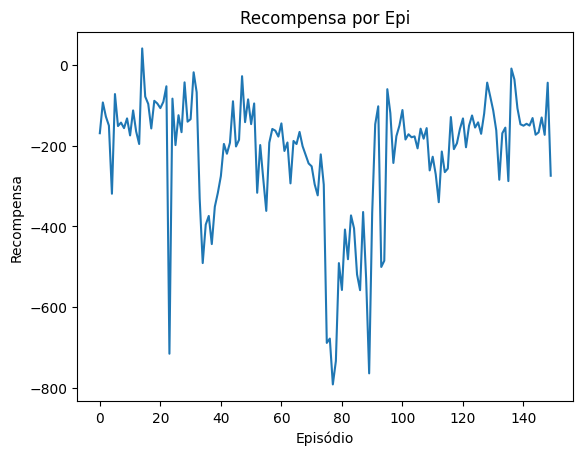

In [4]:

env = gym.make('LunarLanderContinuous-v2')

# Número de ações na saída da Rede Neural
num_actions = env.action_space.shape[0]

# Criar e compilar o agente Q-Learning
agente = QNetworkAgent(num_actions)
otimizador = tf.keras.optimizers.Adam(learning_rate=0.001)

#q-Learning
recompensas_episodio = executar_q_learning(env, agente, otimizador)

plt.plot(recompensas_episodio)
plt.xlabel('Episódio')
plt.ylabel('Recompensa')
plt.title('Recompensa por Epi')
plt.show()